# 1. Imports

In [ ]:
!pip install pandas-path, catboost, xgboost
!pip install --upgrade matplotlib

!git clone --recursive https://github.com/Microsoft/LightGBM
!cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

In [44]:
import itertools
from pathlib import Path
from pandas_path import path
from pprint import pprint
import numpy as np
import pandas as pd

# visualization
from matplotlib import pyplot as plt, cm
import seaborn as sns
from tqdm.notebook import tqdm

# modeling
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import StratifiedKFold, cross_val_score

# models
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

pd.set_option("max_colwidth", 80)
RANDOM_SEED = 42  # For reproducibility

# 2. Data

Competition data isn´t publicly available. Following data structure is expected:

```
../mars_spectrometry/
├── train_features
│   ├── sample_id_1.csv
│   ├── sample_id_2.csv
│   ├── sample_id_3.csv
│   └── ...
├── val_features
│   ├── ...
│   ...
├── test_features
│   ├── ...
│   ...
├── metadata.csv
├── train_labels.csv
├── val_labels.csv
└── submission_format.csv
```

# 3. EDA

In [4]:
DATA_PATH = Path.cwd().parent / "/content/mars_spectrometry/"
metadata = pd.read_csv(DATA_PATH / "metadata.csv", index_col="sample_id")
metadata.head()

,split,instrument_type,features_path,features_md5_hash
sample_id,,,,
S0000,train,commercial,train_features/S0000.csv,017b9a71a702e81a828e6242aa15f049
S0001,train,commercial,train_features/S0001.csv,0d09840214054d254bd49436c6a6f315
S0002,train,commercial,train_features/S0002.csv,3f58b3c9b001bfed6ed4e4f757083e09
S0003,train,commercial,train_features/S0003.csv,e9a12f96114a2fda60b36f4c0f513fb1
S0004,train,commercial,train_features/S0004.csv,b67603d3931897bfa796ac42cc16de78


In [5]:
train_files = metadata[metadata["split"] == "train"]["features_path"].to_dict()
val_files = metadata[metadata["split"] == "val"]["features_path"].to_dict()
test_files = metadata[metadata["split"] == "test"]["features_path"].to_dict()

print("Number of training samples: ", len(train_files))
print("Number of validation samples: ", len(val_files))
print("Number of testing samples: ", len(test_files))

Number of training samples:  766
Number of validation samples:  293
Number of testing samples:  511


[Text(0, 0, '64'), Text(0, 0, '12'), Text(0, 0, '0')]

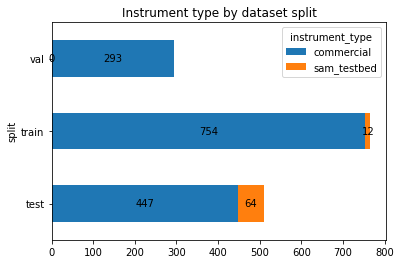

In [6]:
# Share of samples from commercial instruments vs. SAM testbed
meta_instrument = (
    metadata.reset_index()
    .groupby(["split", "instrument_type"])["sample_id"]
    .aggregate("count")
    .reset_index()
)
meta_instrument = meta_instrument.pivot(
    index="split", columns="instrument_type", values="sample_id"
).reset_index()
meta_instrument.head()

ax = meta_instrument.plot(
    x="split",
    kind="barh",
    stacked=True,
    title="Instrument type by dataset split",
    mark_right=True,
)
ax.bar_label(ax.containers[0], label_type="center")
ax.bar_label(ax.containers[1], label_type="center")

In [7]:
train_labels = pd.read_csv(DATA_PATH / "train_labels.csv", index_col="sample_id")
train_labels.head()

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0000,0,0,0,0,0,0,0,0,1,0
S0001,0,1,0,0,0,0,0,0,0,0
S0002,0,0,0,0,0,1,0,0,0,0
S0003,0,1,0,1,0,0,0,0,1,0
S0004,0,0,0,1,0,1,1,0,0,0


In [8]:
val_labels = pd.read_csv(DATA_PATH / "val_labels.csv", index_col="sample_id")
val_labels.head()

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0766,0,0,0,0,0,0,0,0,0,0
S0767,0,0,0,0,0,0,0,0,0,0
S0768,1,0,0,0,0,0,1,1,0,0
S0769,0,0,0,0,0,1,0,0,1,0
S0770,0,0,0,1,0,1,1,0,0,0


Text(0.5, 1.0, 'Compounds represented in training set')

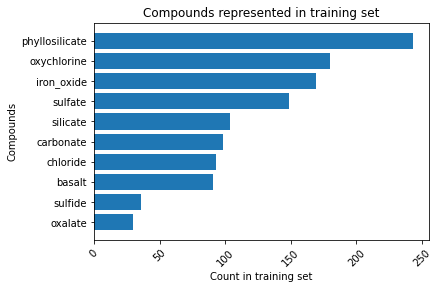

In [9]:
sumlabs = train_labels.aggregate("sum").sort_values()
plt.barh(sumlabs.index, sumlabs, align="center")
plt.ylabel("Compounds")
plt.xticks(rotation=45)
plt.xlabel("Count in training set")
plt.title("Compounds represented in training set")

In [10]:
# Select sample IDs for five commercial samples and five testbed samples
sample_id_commercial = (
    metadata[metadata["instrument_type"] == "commercial"]
    .index
    .values[0:5]
)
sample_id_testbed = (
    metadata[metadata["instrument_type"] == "sam_testbed"]
    .index
    .values[0:5]
)

In [11]:
# Import sample files for EDA
sample_commercial_dict = {}
sample_testbed_dict = {}

for i in range(0, 5):
    comm_lab = sample_id_commercial[i]
    sample_commercial_dict[comm_lab] = pd.read_csv(DATA_PATH / train_files[comm_lab])

    test_lab = sample_id_testbed[i]
    sample_testbed_dict[test_lab] = pd.read_csv(DATA_PATH / train_files[test_lab])

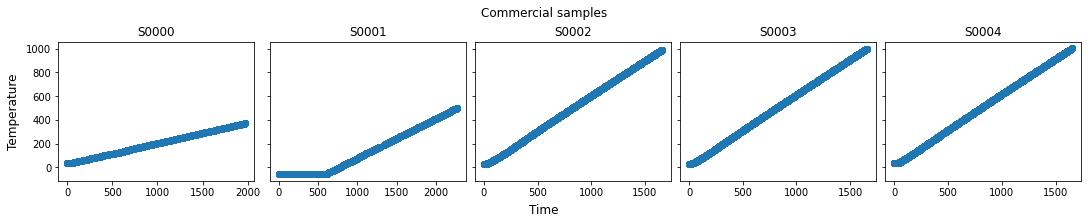

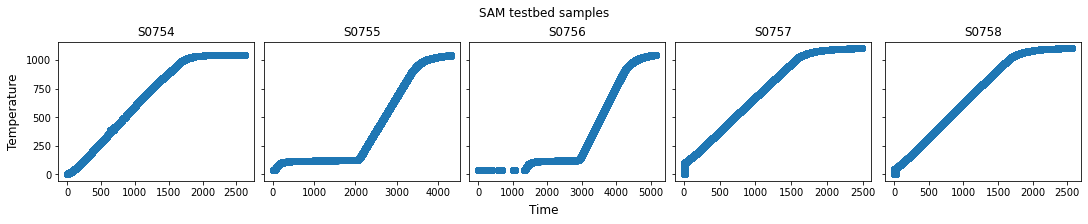

In [12]:
# Plot time vs. temperature for both sample types

# For commercial
fig, ax = plt.subplots(1, 5, figsize=(15, 3), constrained_layout=True, sharey="all")
fig.supylabel("Temperature")
fig.supxlabel("Time")
fig.suptitle("Commercial samples")

for i in range(0, 5):
    sample_lab = sample_id_commercial[i]
    plt.subplot(1, 5, i + 1)
    plt.scatter(
        sample_commercial_dict[sample_lab]["time"],
        sample_commercial_dict[sample_lab]["temp"],
    )
    plt.title(sample_lab)

# For SAM testbed
fig, ax = plt.subplots(1, 5, figsize=(15, 3), constrained_layout=True, sharey="all")
fig.supylabel("Temperature")
fig.supxlabel("Time")
fig.suptitle("SAM testbed samples")

for i in range(0, 5):
    sample_lab = sample_id_testbed[i]
    plt.subplot(1, 5, i + 1)
    plt.scatter(
        sample_testbed_dict[sample_lab]["time"],
        sample_testbed_dict[sample_lab]["temp"],
    )
    plt.title(sample_lab)

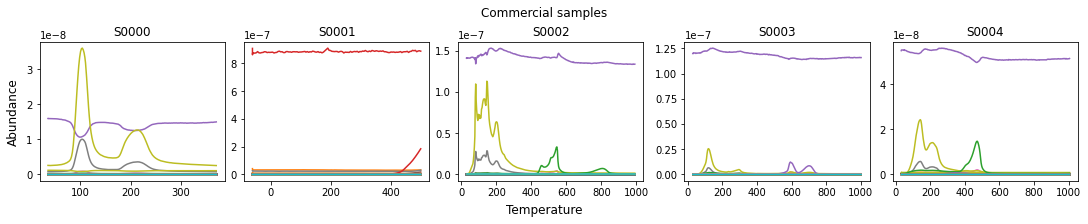

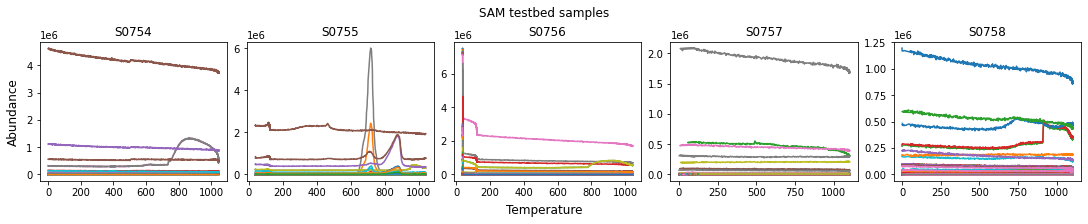

In [13]:
# For commercial
fig, ax = plt.subplots(1, 5, figsize=(15, 3), constrained_layout=True)
fig.suptitle("Commercial samples")
fig.supxlabel("Temperature")
fig.supylabel("Abundance")

for i in range(0, 5):
    sample_lab = sample_id_commercial[i]
    sample_df = sample_commercial_dict[sample_lab]

    plt.subplot(1, 5, i + 1)
    for m in sample_df["m/z"].unique():
        plt.plot(
            sample_df[sample_df["m/z"] == m]["temp"],
            sample_df[sample_df["m/z"] == m]["abundance"],
        )

    plt.title(sample_lab)

# For testbed
fig, ax = plt.subplots(1, 5, figsize=(15, 3), constrained_layout=True)
fig.suptitle("SAM testbed samples")
fig.supxlabel("Temperature")
fig.supylabel("Abundance")

for i in range(0, 5):
    sample_lab = sample_id_testbed[i]
    sample_df = sample_testbed_dict[sample_lab]

    plt.subplot(1, 5, i + 1)
    for m in sample_df["m/z"].unique():
        plt.plot(
            sample_df[sample_df["m/z"] == m]["temp"],
            sample_df[sample_df["m/z"] == m]["abundance"],
        )
    plt.title(sample_lab)

# 4. Preprocessing

In [14]:
# Selecting a testbed sample to demonstrate preprocessing steps
sample_lab = sample_id_testbed[1]
sample_df = sample_testbed_dict[sample_lab]

## 1. Standardizing which m/z values to include

In [15]:
def drop_frac_and_He(df):
    """
    Drops fractional m/z values, m/z values > 100, and carrier gas m/z

    Args:
        df: a dataframe representing a single sample, containing m/z values

    Returns:
        The dataframe without fractional an carrier gas m/z
    """

    # drop fractional m/z values
    df = df[df["m/z"].transform(round) == df["m/z"]]
    assert df["m/z"].apply(float.is_integer).all(), "not all m/z are integers"

    # drop m/z values greater than 99
    df = df[df["m/z"] < 100]

    # drop carrier gas
    df = df[df["m/z"] != 4]

    return df

Text(0.5, 1.0, 'After dropping selected m/z values')

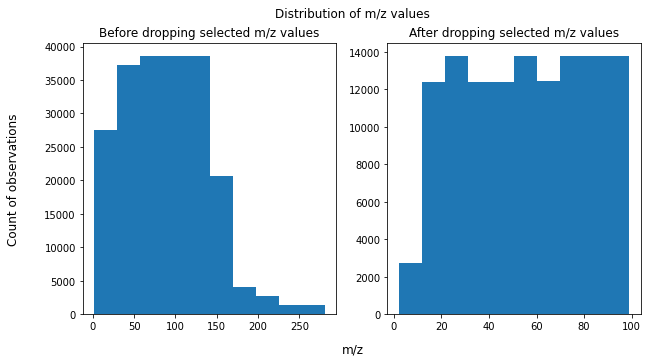

In [16]:
# m/z values before limiting
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Distribution of m/z values")
fig.supxlabel("m/z")
fig.supylabel("Count of observations")

plt.subplot(1, 2, 1)
plt.hist(sample_df["m/z"])
plt.title("Before dropping selected m/z values")

# m/z values after limiting
sample_df = drop_frac_and_He(sample_df)
plt.subplot(1, 2, 2)
plt.hist(sample_df["m/z"])
plt.title("After dropping selected m/z values")

## 2. Removing background ion presences

In [17]:
def remove_background_abundance(df):
    """
    Subtracts minimum abundance value

    Args:
        df: dataframe with 'm/z' and 'abundance' columns

    Returns:
        dataframe with minimum abundance subtracted for all observations
    """

    df["abundance_minsub"] = df.groupby(["m/z"])["abundance"].transform(
        lambda x: (x - x.min())
    )

    return df

Text(0.5, 1.0, 'After subtracting minimum abundance')

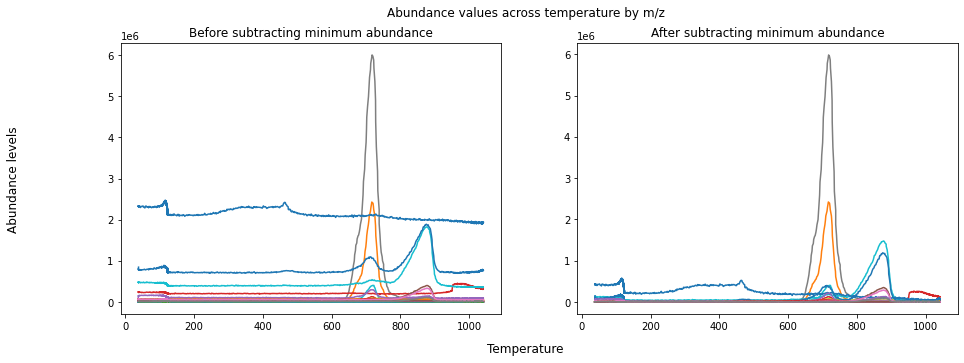

In [18]:
# Abundance values before subtracting minimum
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Abundance values across temperature by m/z")
fig.supxlabel("Temperature")
fig.supylabel("Abundance levels")

plt.subplot(1, 2, 1)
for m in sample_df["m/z"].unique():
    plt.plot(
        sample_df[sample_df["m/z"] == m]["temp"],
        sample_df[sample_df["m/z"] == m]["abundance"],
    )
plt.title("Before subtracting minimum abundance")

# After subtracting minimum abundance value
sample_df = remove_background_abundance(sample_df)

plt.subplot(1, 2, 2)
for m in sample_df["m/z"].unique():
    plt.plot(
        sample_df[sample_df["m/z"] == m]["temp"],
        sample_df[sample_df["m/z"] == m]["abundance_minsub"],
    )
plt.title("After subtracting minimum abundance")

## 3. Convert abundances to relative abundances

In [19]:
def scale_abun(df):
    """
    Scale abundance from 0-100 according to the min and max values across entire sample

    Args:
        df: dataframe containing abundances and m/z

    Returns:
        dataframe with additional column of scaled abundances
    """

    df["abun_minsub_scaled"] = minmax_scale(df["abundance_minsub"].astype(float))

    return df

## 4. Putting it all together

In [20]:
# Preprocess function
def preprocess_sample(df):
    df = drop_frac_and_He(df)
    df = remove_background_abundance(df)
    df = scale_abun(df)
    return df

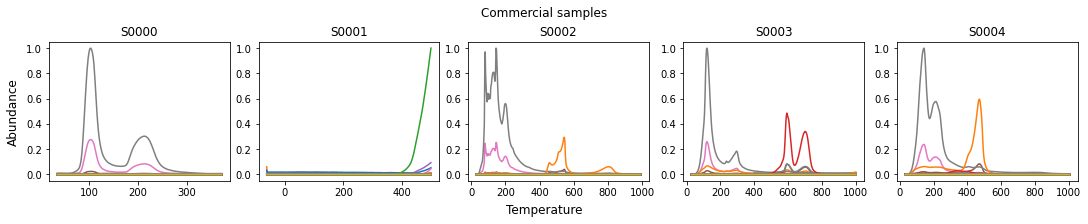

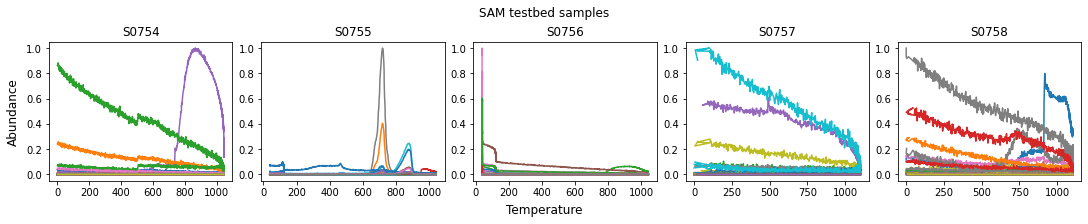

In [21]:
# For commercial
fig, ax = plt.subplots(1, 5, figsize=(15, 3), constrained_layout=True)
fig.suptitle("Commercial samples")
fig.supxlabel("Temperature")
fig.supylabel("Abundance")

for i in range(0, 5):
    sample_lab = sample_id_commercial[i]
    sample_df = sample_commercial_dict[sample_lab]
    sample_df = preprocess_sample(sample_df)

    plt.subplot(1, 5, i + 1)
    for m in sample_df["m/z"].unique():
        plt.plot(
            sample_df[sample_df["m/z"] == m]["temp"],
            sample_df[sample_df["m/z"] == m]["abun_minsub_scaled"],
        )

    plt.title(sample_lab)

# For testbed
fig, ax = plt.subplots(1, 5, figsize=(15, 3), constrained_layout=True)
fig.suptitle("SAM testbed samples")
fig.supxlabel("Temperature")
fig.supylabel("Abundance")

for i in range(0, 5):
    sample_lab = sample_id_testbed[i]
    sample_df = sample_testbed_dict[sample_lab]
    sample_df = preprocess_sample(sample_df)

    plt.subplot(1, 5, i + 1)
    for m in sample_df["m/z"].unique():
        plt.plot(
            sample_df[sample_df["m/z"] == m]["temp"],
            sample_df[sample_df["m/z"] == m]["abun_minsub_scaled"],
        )
    plt.title(sample_lab)

# 5. Feature Engineering

In [22]:
# Create a series of temperature bins
temprange = pd.interval_range(start=0, end=1500, freq=100)
temprange

# Make dataframe with rows that are combinations of all temperature bins
# and all m/z values
allcombs = list(itertools.product(temprange, [*range(0, 100)]))

allcombs_df = pd.DataFrame(allcombs, columns=["temp_bin", "m/z"])
allcombs_df.head()

,temp_bin,m/z
0,"(0, 100]",0
1,"(0, 100]",1
2,"(0, 100]",2
3,"(0, 100]",3
4,"(0, 100]",4


In [23]:
def abun_per_tempbin(df):

    """
    Transforms dataset to take the preprocessed max abundance for each
    temperature range for each m/z value

    Args:
        df: dataframe to transform

    Returns:
        transformed dataframe
    """

    # Bin temperatures
    df["temp_bin"] = pd.cut(df["temp"], bins=temprange)

    # Combine with a list of all temp bin-m/z value combinations
    df = pd.merge(allcombs_df, df, on=["temp_bin", "m/z"], how="left")

    # Aggregate to temperature bin level to find max
    df = df.groupby(["temp_bin", "m/z"]).max("abun_minsub_scaled").reset_index()

    # Fill in 0 for abundance values without information
    df = df.replace(np.nan, 0)

    # Reshape so each row is a single sample
    df = df.pivot_table(columns=["m/z", "temp_bin"], values=["abun_minsub_scaled"])

    return df

In [24]:
# Assembling preprocessed and transformed training set
def prepare_features(train_files):
    """
    Preprocesses and feature engineers the features for training.

    Args:
        train_files: a dictionary with sample_ids and the corresponding csv paths

    Returns:
        The dataframe with the preprocessed and scaled features
    """

    train_features_dict = {}
    print("Total number of train files: ", len(train_files))

    for i, (sample_id, filepath) in enumerate(tqdm(train_files.items())):

        # Load training sample
        temp = pd.read_csv(DATA_PATH / filepath)

        # Preprocessing training sample
        train_sample_pp = preprocess_sample(temp)

        # Feature engineering
        train_sample_fe = abun_per_tempbin(train_sample_pp).reset_index(drop=True)
        train_features_dict[sample_id] = train_sample_fe

    train_features = pd.concat(
        train_features_dict, names=["sample_id", "dummy_index"]
    ).reset_index(level="dummy_index", drop=True)

    return train_features

In [25]:
train_features = prepare_features(train_files)
val_features = prepare_features(val_files)

Total number of train files:  766


  0%|          | 0/766 [00:00<?, ?it/s]

Total number of train files:  293


  0%|          | 0/293 [00:00<?, ?it/s]

In [26]:
train_features.head()

m/z              0                                                          \
temp_bin   (0, 100] (100, 200] (200, 300] (300, 400] (400, 500] (500, 600]   
sample_id                                                                    
S0000      0.004085   0.004641   0.001394   0.000188   0.000000   0.000000   
S0001      0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
S0002      0.002270   0.002495   0.001688   0.000636   0.000597   0.000819   
S0003      0.001336   0.002464   0.001099   0.000992   0.000676   0.000883   
S0004      0.005993   0.012429   0.009380   0.005099   0.006921   0.001966   

m/z                                                     ...         99  \
temp_bin  (600, 700] (700, 800] (800, 900] (900, 1000]  ... (500, 600]   
sample_id                                               ...              
S0000       0.000000   0.000000   0.000000    0.000000  ...   0.000000   
S0001       0.000000   0.000000   0.000000    0.000000  ...   0.000000   
S0002       0.000155   0.000235   0.000227    0.000086  ...   0.000001   
S0003       0.000892   0.000631   0.000361    0.000299  ...   0.000005   
S0004       0.000499   0.000880   0.000767    0.000903  ...   0.000005   

m/z                                                                     \
temp_bin     (600, 700] (700, 800] (800, 900] (900, 1000] (1000, 1100]   
sample_id                                                                
S0000      0.000000e+00   0.000000   0.000000    0.000000     0.000000   
S0001      0.000000e+00   0.000000   0.000000    0.000000     0.000000   
S0002      9.397170e-07   0.000001   0.000001    0.000001     0.000000   
S0003      4.693477e-06   0.000004   0.000004    0.000004     0.000003   
S0004      3.174421e-06   0.000004   0.000004    0.000003     0.000004   

m/z                                                            
temp_bin  (1100, 1200] (1200, 1300] (1300, 1400] (1400, 1500]  
sample_id                                                      
S0000              0.0          0.0          0.0          0.0  
S0001              0.0          0.0          0.0          0.0  
S0002              0.0          0.0          0.0          0.0  
S0003              0.0          0.0          0.0          0.0  
S0004              0.0          0.0          0.0          0.0  

[5 rows x 1500 columns]

In [27]:
# Make sure that all sample IDs in features and labels are identical
assert train_features.index.equals(train_labels.index)

# 6. Perform Modeling

In [28]:
# Define stratified k-fold validation
skf = StratifiedKFold(n_splits=10, random_state=RANDOM_SEED, shuffle=True)

# Define log loss
log_loss_scorer = make_scorer(log_loss, needs_proba=True)

In [38]:
# Check log loss score for baseline dummy model
def logloss_cross_val(clf, X, y):

    # Generate a score for each label class
    log_loss_cv = {}
    for col in y.columns:

        y_col = y[col]  # take one label at a time
        log_loss_cv[col] = np.mean(
            cross_val_score(clf, X.values, y_col, cv=skf, scoring=log_loss_scorer)
        )

    avg_log_loss = np.mean(list(log_loss_cv.values()))

    return log_loss_cv, avg_log_loss

## Baseline dummy classifier

In [39]:
# Dummy classifier
dummy_clf = DummyClassifier(strategy="prior")

# Cross Validation
print("Dummy model log-loss:")
dummy_labelwise_logloss, dummy_avg_logloss = logloss_cross_val(dummy_clf, train_features, train_labels)
pprint(dummy_labelwise_logloss)
print("\nAverage log-loss")
dummy_avg_logloss

Dummy model log-loss:
{'basalt': 0.3645372208379112,
 'carbonate': 0.3824414251351717,
 'chloride': 0.3697285633598953,
 'iron_oxide': 0.5277071928108552,
 'oxalate': 0.16528503978963754,
 'oxychlorine': 0.5452451136713539,
 'phyllosilicate': 0.6247744558229936,
 'silicate': 0.39720419245594735,
 'sulfate': 0.49271320494614584,
 'sulfide': 0.18955707573177416}

Average log-loss


0.40591934845616856

## Logistic regression model

In [47]:
# Define logistic regression model
logreg_clf = LogisticRegression(
    penalty="l1", solver="liblinear", C=10, random_state=RANDOM_SEED
)
print("Logistic regression model log-loss:\n")
logreg_labelwise_logloss, logreg_avg_logloss = logloss_cross_val(logreg_clf, train_features, train_labels)
pprint(logreg_labelwise_logloss)
print("Average log-loss")
logreg_avg_logloss

Logistic regression model log-loss:

{'basalt': 0.27672359546453806,
 'carbonate': 0.2614589394727089,
 'chloride': 0.2841182874837477,
 'iron_oxide': 0.38376399163199165,
 'oxalate': 0.004094102362585186,
 'oxychlorine': 0.29910400940977827,
 'phyllosilicate': 0.4110026855029848,
 'silicate': 0.35111797415663965,
 'sulfate': 0.3446689121220305,
 'sulfide': 0.13631160119625768}
Average log-loss


0.2752364098803262

## XGBoost model

In [33]:
# Define the model
xgboost_model = XGBClassifier(
    objective='binary:logistic',
    tree_method='gpu_hist',
    gpu_id=0,
    seed=RANDOM_SEED
    )

print("XGBoost model log-loss:\n")
xgboost_labelwise_logloss, xgboost_avg_logloss = logloss_cross_val(xgboost_model, train_features, train_labels)
print(xgboost_labelwise_logloss)
print("Average log-loss")
xgboost_avg_logloss

XGBoost model log-loss:

{'basalt': 0.2048042224619102, 'carbonate': 0.13357722719604742, 'chloride': 0.19081779801383258, 'iron_oxide': 0.2282876959209538, 'oxalate': 0.02619778705282484, 'oxychlorine': 0.19990084894222576, 'phyllosilicate': 0.2718878906244667, 'silicate': 0.22779872838696663, 'sulfate': 0.20202114710406177, 'sulfide': 0.07551884889244612}
Average log-loss


0.1760812194595736

## CatBoost model

In [42]:
# Define the model. Adding iterations parameters to speed up pred.
catboost_model = CatBoostClassifier(
    task_type='GPU',
    iterations=250,
    random_seed=RANDOM_SEED,
    silent=True
    )

print("CatBoost model log-loss:\n")
catboost_labelwise_logloss, catboost_avg_logloss = logloss_cross_val(catboost_model, train_features, train_labels)
print(catboost_labelwise_logloss)
print("Average log-loss")
catboost_avg_logloss

CatBoost model log-loss:

{'basalt': 0.21887766313698456, 'carbonate': 0.14202721119814415, 'chloride': 0.2017391712910893, 'iron_oxide': 0.23234814410597476, 'oxalate': 0.023221540586441016, 'oxychlorine': 0.2039719944368204, 'phyllosilicate': 0.26827676210542806, 'silicate': 0.24054264940687817, 'sulfate': 0.2207616145389581, 'sulfide': 0.09127113676510631}
Average log-loss


0.1843037887571825

## LightGBM model

In [45]:
# Define the model
lightgbm_model = LGBMClassifier(
    objective='binary',
    device_type='gpu',
    random_seed=RANDOM_SEED,
    verbose=-1
)

print("LightGBM model log-loss:\n")
lightgbm_labelwise_logloss, lightgbm_avg_logloss = logloss_cross_val(lightgbm_model, train_features, train_labels)
print(lightgbm_labelwise_logloss)
print("Average log-loss")
lightgbm_avg_logloss

LightGBM model log-loss:

{'basalt': 0.2724098706088447, 'carbonate': 0.17389896569613236, 'chloride': 0.29201949205004085, 'iron_oxide': 0.2696584949125955, 'oxalate': 0.05909615464942266, 'oxychlorine': 0.2608955521550483, 'phyllosilicate': 0.31594809483366404, 'silicate': 0.3536488986996479, 'sulfate': 0.2795565018890081, 'sulfide': 0.1172351142285039}
Average log-loss


0.23943671397229083

# 7. Compare performance before optimization

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'dummy_clf'),
  Text(1, 0, 'log_reg_model'),
  Text(2, 0, 'xgboost'),
  Text(3, 0, 'catboost'),
  Text(4, 0, 'lightgbm')])

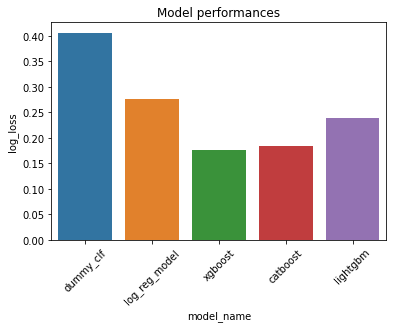

In [48]:
# Create dictionary with model_names and their corresponding performance
model_names = {'dummy_clf':dummy_avg_logloss,
               'log_reg_model':logreg_avg_logloss,
               'xgboost':xgboost_avg_logloss,
               'catboost':catboost_avg_logloss,
               'lightgbm':lightgbm_avg_logloss}

# Plot the results (lower is better)
ax = sns.barplot(x=list(model_names.keys()), y=list(model_names.values()))
plt.title("Model performances")
plt.xlabel('model_name')
plt.ylabel('log_loss')
plt.xticks(rotation=45)

# 8. Optuna optimization

## Install/Import

In [ ]:
!pip install optuna

import optuna

## XGBoost optimization

In [50]:
# define hyperparameters and scopes
def objective(trial):

    # Define model parameters
    params = {
        "depth": trial.suggest_int("depth", 3, 12, step=1),
        "n_estimators": trial.suggest_int("n_estimators", 80, 500, step=10),
        "iterations": trial.suggest_int("iterations", 80, 500, step=10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0, step=0.01),
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
    }

    # Define model
    model = XGBClassifier(**params,
                        objective='binary:logistic',
                        eval_metric= "logloss",
                        tree_method='gpu_hist',
                        gpu_id=0,
                        seed=RANDOM_SEED
                        )
    
    
    # Evaluate log_loss for each label
    aggr_log_loss = {}

    for col in val_labels.columns:

        train_y_col = train_labels[col]
        val_y_col = val_labels[col]

        model.fit(
            train_features.values,
            train_y_col
            )

        pred_labels = model.predict_proba(val_features.values)
        aggr_log_loss[col] = log_loss(y_true=val_y_col.values, y_pred=pred_labels, labels=[0,1])

    # Calculate aggregated log_loss
    avg_log_loss = np.mean(list(aggr_log_loss.values()))

    return avg_log_loss

xgboost_study = optuna.create_study(direction="minimize", study_name='XGBoost optimization')
xgboost_study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: ", len(xgboost_study.trials))
print("Best trial:")
xgboost_trial = xgboost_study.best_trial

print("  Value: {}".format(xgboost_trial.value))
print("  Params: ")
for key, value in xgboost_trial.params.items():

    print("    {}: {}".format(key, value))

[I 2022-04-21 20:04:24,540] A new study created in memory with name: XGBoost optimization
[I 2022-04-21 20:04:40,337] Trial 0 finished with value: 0.16658454721823482 and parameters: {'depth': 5, 'n_estimators': 400, 'iterations': 80, 'learning_rate': 0.13, 'lambda': 0.00288632979835963, 'alpha': 0.042126769442889164}. Best is trial 0 with value: 0.16658454721823482.
[I 2022-04-21 20:04:49,350] Trial 1 finished with value: 0.1706214995843769 and parameters: {'depth': 9, 'n_estimators': 130, 'iterations': 80, 'learning_rate': 0.32, 'lambda': 0.32371728751351364, 'alpha': 0.012520451149282406}. Best is trial 0 with value: 0.16658454721823482.
[I 2022-04-21 20:05:02,289] Trial 2 finished with value: 0.17912825143550926 and parameters: {'depth': 6, 'n_estimators': 340, 'iterations': 390, 'learning_rate': 0.44, 'lambda': 3.701481341922972, 'alpha': 0.3287101719128261}. Best is trial 0 with value: 0.16658454721823482.
[I 2022-04-21 20:05:18,062] Trial 3 finished with value: 0.183962376777926

Number of finished trials:  50
Best trial:
  Value: 0.1561850297605533
  Params: 
    depth: 11
    n_estimators: 270
    iterations: 130
    learning_rate: 0.060000000000000005
    lambda: 0.070494218855612
    alpha: 0.05277449197608768


In [51]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(xgboost_study)

In [52]:
# Visualize parameter importances.
optuna.visualization.plot_param_importances(xgboost_study)

## Catboost optimization

In [53]:
from catboost import Pool

In [63]:
def objective(trial):

    # Define model parameter scopes
    catboost_param = {
        "iterations": trial.suggest_int("iterations", 10, 200, step=10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0, step=0.01),
        "depth": trial.suggest_int("depth", 4, 10, step=1),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 4, step=1),
        "border_count": trial.suggest_int("border_count", 1,255 , step=1)
    }

    # Define model
    model = CatBoostClassifier(**catboost_param,
                               objective='Logloss',
                               loss_function='Logloss',
                               task_type='GPU',
                               random_seed=RANDOM_SEED,
                               silent=True
                               )
    
    # Evaluate log_loss for each label
    aggr_log_loss = {}

    for col in val_labels.columns:

        train_y_col = train_labels[col]
        val_y_col = val_labels[col]

        pool = Pool(data=train_features.values, label=train_y_col)  
        model.fit(pool)

        pred_labels = model.predict_proba(val_features.values)
        aggr_log_loss[col] = log_loss(y_true=val_y_col.values, y_pred=pred_labels, labels=[0,1])

    # Calculate aggregated log_loss
    avg_log_loss = np.mean(list(aggr_log_loss.values()))

    return avg_log_loss


catboost_study = optuna.create_study(direction="minimize", study_name='CatBoost optimization')
catboost_study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: ", len(catboost_study.trials))
print("Best trial:")
catboost_trial = catboost_study.best_trial

print("  Value: {}".format(catboost_trial.value))
print("  Params: ")
for key, value in catboost_trial.params.items():

    print("    {}: {}".format(key, value))

[I 2022-04-21 21:23:55,925] A new study created in memory with name: CatBoost optimization
[I 2022-04-21 21:24:31,652] Trial 0 finished with value: 0.2011284955822706 and parameters: {'iterations': 170, 'learning_rate': 0.03, 'depth': 4, 'l2_leaf_reg': 2, 'border_count': 213}. Best is trial 0 with value: 0.2011284955822706.
[I 2022-04-21 21:25:05,213] Trial 1 finished with value: 0.23205987725946833 and parameters: {'iterations': 170, 'learning_rate': 0.8400000000000001, 'depth': 7, 'l2_leaf_reg': 1, 'border_count': 22}. Best is trial 0 with value: 0.2011284955822706.
[I 2022-04-21 21:25:17,082] Trial 2 finished with value: 0.20905687438786952 and parameters: {'iterations': 10, 'learning_rate': 0.31, 'depth': 9, 'l2_leaf_reg': 2, 'border_count': 28}. Best is trial 0 with value: 0.2011284955822706.
[I 2022-04-21 21:25:45,993] Trial 3 finished with value: 0.18760980856657072 and parameters: {'iterations': 80, 'learning_rate': 0.43, 'depth': 9, 'l2_leaf_reg': 3, 'border_count': 19}. Best 

Number of finished trials:  19
Best trial:
  Value: 0.1656859419312326
  Params: 
    iterations: 80
    learning_rate: 0.27
    depth: 6
    l2_leaf_reg: 4
    border_count: 248


In [64]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(catboost_study)

In [56]:
# Visualize parameter importances.
optuna.visualization.plot_param_importances(catboost_study)

## LightGBM optimization

In [57]:
def objective(trial):

    # Define model parameter scopes
    lightgbm_param = {
        "n_estimators": trial.suggest_int("n_estimators", 80, 1000, step=10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 18, step=1),
        "num_leaves": trial.suggest_int('num_leaves', 2, 12, step=1),
        "max_bin": trial.suggest_int('max_bin', 25, 255, step=1)
    }

    # Define model
    model = LGBMClassifier(**lightgbm_param,
        objective='binary',
        device_type='gpu',
        random_seed=RANDOM_SEED,
        verbose=-1
    )

    # Evaluate log_loss for each label
    aggr_log_loss = {}

    for col in val_labels.columns:

        train_y_col = train_labels[col]
        val_y_col = val_labels[col]

        model.fit(
            train_features.values,
            train_y_col
            )

        pred_labels = model.predict_proba(val_features.values)
        aggr_log_loss[col] = log_loss(y_true=val_y_col.values, y_pred=pred_labels, labels=[0,1])

    # Calculate aggregated log_loss
    avg_log_loss = np.mean(list(aggr_log_loss.values()))

    return avg_log_loss


lightgbm_study = optuna.create_study(direction="minimize", study_name='LightGBM optimization')
lightgbm_study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: ", len(lightgbm_study.trials))
print("Best trial:")
lightgbm_trial = lightgbm_study.best_trial

print("  Value: {}".format(lightgbm_trial.value))
print("  Params: ")
for key, value in lightgbm_trial.params.items():

    print("    {}: {}".format(key, value))

[I 2022-04-21 20:36:16,984] A new study created in memory with name: LightGBM optimization
[I 2022-04-21 20:36:31,001] Trial 0 finished with value: 0.32447133707751674 and parameters: {'n_estimators': 530, 'learning_rate': 0.41000000000000003, 'max_depth': 7, 'num_leaves': 6, 'max_bin': 35}. Best is trial 0 with value: 0.32447133707751674.
[I 2022-04-21 20:36:50,984] Trial 1 finished with value: 0.9213429188623252 and parameters: {'n_estimators': 600, 'learning_rate': 0.8200000000000001, 'max_depth': 5, 'num_leaves': 7, 'max_bin': 170}. Best is trial 0 with value: 0.32447133707751674.
[I 2022-04-21 20:37:14,679] Trial 2 finished with value: 0.8782220570917417 and parameters: {'n_estimators': 580, 'learning_rate': 0.59, 'max_depth': 17, 'num_leaves': 7, 'max_bin': 117}. Best is trial 0 with value: 0.32447133707751674.
[I 2022-04-21 20:37:56,421] Trial 3 finished with value: 0.3113087476668822 and parameters: {'n_estimators': 360, 'learning_rate': 0.27, 'max_depth': 14, 'num_leaves': 10,

Number of finished trials:  25
Best trial:
  Value: 0.16829793995794928
  Params: 
    n_estimators: 430
    learning_rate: 0.02
    max_depth: 16
    num_leaves: 5
    max_bin: 193


In [58]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(lightgbm_study)

In [59]:
# Visualize parameter importances.
optuna.visualization.plot_param_importances(lightgbm_study)

# 8. Compare models after optimization

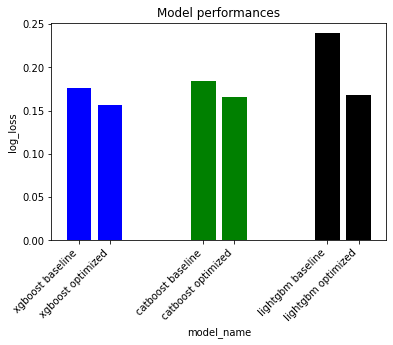

In [75]:
# Group before and after optimization model performances
model_groups = [xgboost_avg_logloss, xgboost_trial.value, # xgboost
                catboost_avg_logloss, catboost_trial.value, #catboost
                lightgbm_avg_logloss, lightgbm_trial.value # lightgbm
                ]

# Corresponding labels
group_labels = ['xgboost baseline', 'xgboost optimized', 'catboost baseline', 'catboost optimized', 'lightgbm baseline', 'lightgbm optimized']

# Set positions for each bar on x-axis (grouping)
x_pos = [0,1,4,5,8,9]

# Create bars with fitting colors
plt.bar(x_pos, model_groups, color=['blue', 'blue', 'green', 'green', 'black', 'black'])
 
# Create names on the x-axis
plt.xticks(x_pos, group_labels)
plt.xticks(rotation=45, ha="right")

# Labeling
plt.title("Model performances")
plt.xlabel('model_name')
plt.ylabel('log_loss')
 
# Show graphic
plt.show()

# 9. Training the models on all of the data

In [76]:
# Merge both preprocessed feature dataframes
all_features = pd.concat([train_features, val_features])

# Merge both label dataframes
all_labels = pd.concat([train_labels, val_labels])

In [77]:
# Initialize dict to hold fitted models
def create_fitted_model_dict(model_name, model_params, labels, features):
    fitted_logreg_dict = {}

    # Split into binary classifier for each class
    for col in labels.columns:
        y_train_col = labels[col]  # Train on one class at a time

        if model_name == 'xgboost':
            model = XGBClassifier(**model_params)
        elif model_name == 'catboost':
            model = CatBoostClassifier(**model_params)
        elif model_name == 'lightgbm':
            model = LGBMClassifier(**model_params)
        else:
            raise Exception('Unknown model name!')
        
        fitted_logreg_dict[col] = model.fit(features.values, y_train_col)  # Train

    return fitted_logreg_dict

In [78]:
xgboost_model_params = {
    'tree_method':'gpu_hist',
    'objective':'binary:logistic',
    'gpu_id':0,
    'seed':RANDOM_SEED,
    }
    
# Add params acquired by optuna optimization
xgboost_model_params.update(xgboost_trial.params)

fitted_xgboost_dict = create_fitted_model_dict('xgboost', xgboost_model_params, all_labels, all_features)

In [79]:
catboost_model_params = {
    'task_type':'GPU',
    'random_seed':RANDOM_SEED,
    'silent':True,
    }

# Add params acquired by optuna optimization
catboost_model_params.update(catboost_trial.params)

fitted_catboost_dict = create_fitted_model_dict('catboost', catboost_model_params, all_labels, all_features)

In [80]:
lightgbm_model_params = {
    'objective':'binary',
    'device_type':'gpu',
    'random_seed':RANDOM_SEED,
    'verbose':-1
    }

# Add params acquired by optuna optimization
lightgbm_model_params.update(lightgbm_trial.params)

fitted_lightgbm_dict = create_fitted_model_dict('lightgbm', lightgbm_model_params, all_labels, all_features)

# 10. Preparing a submission

In [81]:
def predict_for_sample(sample_id, fitted_model_dict, files, compounds_order):

    # Import sample
    temp_sample = pd.read_csv(DATA_PATH / files[sample_id])

    # Preprocess sample
    temp_sample = preprocess_sample(temp_sample)

    # Feature engineering on sample
    temp_sample = abun_per_tempbin(temp_sample)

    # Generate predictions for each class
    temp_sample_preds_dict = {}

    for compound in compounds_order:
        clf = fitted_model_dict[compound]
        temp_sample_preds_dict[compound] = clf.predict_proba(temp_sample.values)[:, 1][0]

    return temp_sample_preds_dict

In [82]:
# Import submission format
submission_template_df = pd.read_csv(
    DATA_PATH / "submission_format.csv", index_col="sample_id"
)
compounds_order = submission_template_df.columns
sample_order = submission_template_df.index

# Create dict with both validation and test sample IDs and paths
all_test_files = test_files.copy()
all_test_files.update(val_files)

## Inference on each model

In [83]:
# XGBoost predictions
xgboost_submission_df = pd.DataFrame(
    [
        predict_for_sample(sample_id, fitted_xgboost_dict, all_test_files, compounds_order)
        for sample_id in tqdm(sample_order)
    ],
    index=sample_order,
)

  0%|          | 0/804 [00:00<?, ?it/s]

In [84]:
# CatBoost predictions
catboost_submission_df = pd.DataFrame(
    [
        predict_for_sample(sample_id, fitted_catboost_dict, all_test_files, compounds_order)
        for sample_id in tqdm(sample_order)
    ],
    index=sample_order,
)

  0%|          | 0/804 [00:00<?, ?it/s]

In [85]:
# LightGBM predictions
lightgbm_submission_df = pd.DataFrame(
    [
        predict_for_sample(sample_id, fitted_lightgbm_dict, all_test_files, compounds_order)
        for sample_id in tqdm(sample_order)
    ],
    index=sample_order,
)

  0%|          | 0/804 [00:00<?, ?it/s]

## Stack predictions & take average

In [86]:
# Stacked prediction and take average of all 3 model preditictions
final_submission_df = (xgboost_submission_df+catboost_submission_df+lightgbm_submission_df)/3
final_submission_df.head()

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0766,0.002441,0.001332,0.010178,0.010396,0.000211,0.007367,0.015185,0.103990,0.002720,0.000571
S0767,0.021792,0.017664,0.001783,0.022095,0.000134,0.005550,0.032132,0.075339,0.011882,0.000371
S0768,0.890998,0.072644,0.002076,0.047650,0.000311,0.018337,0.722315,0.895352,0.055063,0.000242
S0769,0.008833,0.001750,0.047314,0.037409,0.000156,0.945314,0.016984,0.003225,0.912814,0.000631
S0770,0.003607,0.001922,0.008824,0.745228,0.000339,0.978265,0.938980,0.001836,0.003916,0.000135


In [87]:
final_submission_df.to_csv('submission_.csv')